In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from data import make_grid

In [2]:
grid = make_grid("GB", 0.1).drop(columns=["pop_density"])

Matching birds to grid cells: 

 99%|█████████▉| 99/100 [00:06<00:00, 16.63it/s]/Users/leoware/Documents/ns166_final_analysis/data/make_grid.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[spec] = counts
100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


In [3]:
id_col = ["lon", "lat"]
cov_col = ['avg_temp', 'avg_min_month', 'avg_max_month']
target_col = grid.columns.difference(id_col + cov_col)

# Test Encodings

In [4]:
def test_df(df):
    models = [LinearRegression(), RandomForestRegressor()]
    model_scores = {}
    model_scores_train = {}
    for model in models:
        model_scores[model.__class__.__name__] = []
        model_scores_train[model.__class__.__name__] = []

    X = df[cov_col]
    Y = df[target_col]

    for model in models:
        print("Fitting model: ", model.__class__.__name__, end="")
        for target in tqdm(Y.columns):
            scores = cross_validate(
                model,
                X,
                Y[target],
                cv=5,
                scoring=["r2"],
                return_train_score=True,
            )
            model_scores[model.__class__.__name__].append(scores["test_r2"].mean())
            model_scores_train[model.__class__.__name__].append(scores["train_r2"].mean())

    return pd.DataFrame(model_scores, index=Y.columns), pd.DataFrame(model_scores_train, index=Y.columns)

In [5]:
res = test_df(grid)

Fitting model:  LinearRegression

100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


Fitting model:  RandomForestRegressor

100%|██████████| 100/100 [08:47<00:00,  5.27s/it]


In [6]:
log_grid = grid.copy()
log_grid[target_col] = np.log(log_grid[target_col] + 1)

g_res = test_df(log_grid)

Fitting model:  LinearRegression

100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


Fitting model:  RandomForestRegressor

100%|██████████| 100/100 [08:18<00:00,  4.99s/it]


In [7]:
prop_grid = grid.copy()
prop_grid[target_col] = prop_grid[target_col] / prop_grid[target_col].sum(axis=1).values.reshape(-1, 1)

p_res = test_df(prop_grid)

Fitting model:  LinearRegression

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 678, in fit
    X, y = self._validate_data(
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1162, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1172, in _check_y
    y = check_array(
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains NaN.


# Analyze Results

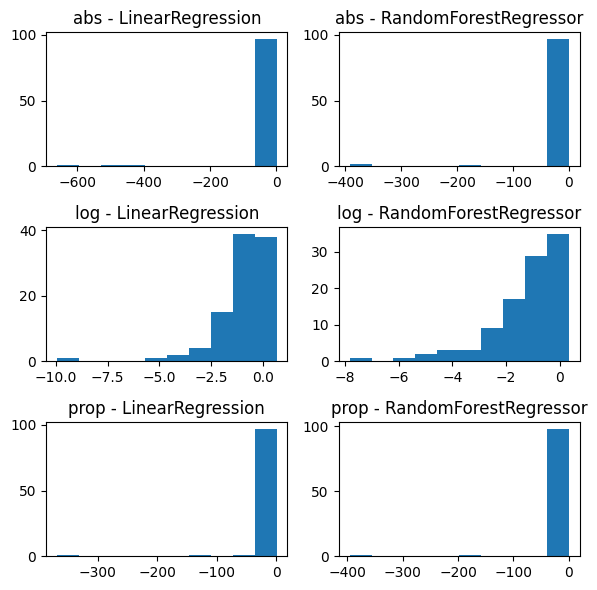

In [ ]:
encodings = {
    "abs": res,
    "log": g_res,
    "prop": p_res,
}

fig, axes = plt.subplots(3, 2, figsize=(6, 6))
axes = iter(axes.flat)

for name, df in encodings.items():
    for model in res.columns:
        ax = next(axes)
        ax.set_title(f"{name} - {model}")
        ax.hist(df[model])

plt.tight_layout()